In [1]:
import sys
sys.path.append('../')
from utils import utils
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


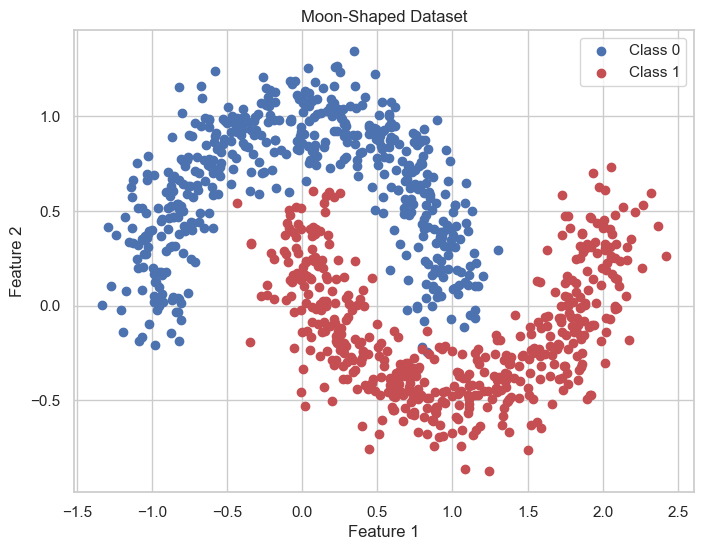

In [2]:
## get data

# Create a moon-shaped dataset with 1000 samples
X, y = utils.make_moons(n_samples=1000, noise=0.15, random_state=42)

# X contains the data points, and y contains their corresponding labels (0 or 1)
utils.plot_moons(X, y)

#### Single Gaussian

The best estimated gaussian is the one with the mean and covariance of the intial data. No need for EM.

 <div style="color: green; font-weight:
bold">The gaussian is built in the same way as the provided solution, but we use multivariate_normal to compute the gaussian instead of building it from scratch. We used the sampling method from sklearn instead of implementing it.</div>

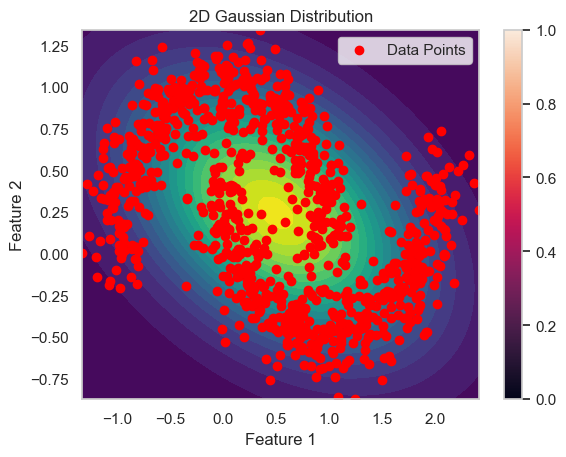

In [3]:
mean_x = np.mean(X[:, 0])
mean_y = np.mean(X[:, 1])
cov_matrix = np.cov(X, rowvar=False)  # rowvar=False ensures data columns represent dimensions

gaussian = multivariate_normal(mean=[mean_x, mean_y], cov=cov_matrix)
# Generate a grid of points for the contour plot
x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                   np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
grid = np.dstack((x, y))

# Evaluate the Gaussian PDF at each point in the grid
pdf_values = gaussian.pdf(grid)
samples = gaussian.rvs(size=1000)

# Create a contour plot
plt.contourf(x, y, pdf_values, levels=20, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], color='red', marker='o', label='Data Points')

# Set labels and a legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Gaussian Distribution')
plt.legend()

# Show the plot
plt.colorbar()
plt.show()

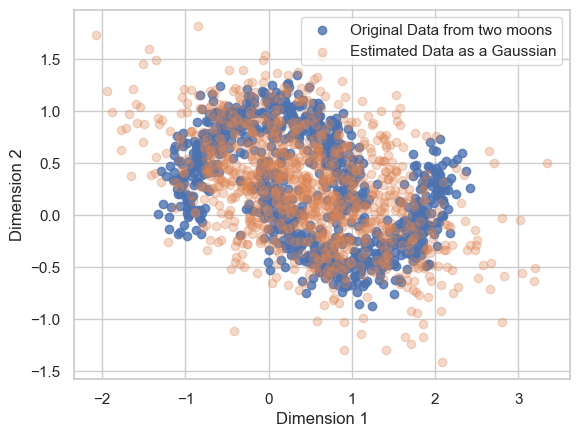

In [4]:
utils.plot_estimated_real_two_moons(X,samples)

 <div style="color: green; font-weight:
bold">MMD function can be found in utils as well. The implementation is the one provided in the link of the assigment with a slight modification for the new kernel.</div>

In [12]:
import torch

result = utils.MMD(torch.tensor(X), torch.tensor(samples), kernel="inverse_multi_quadratic")

print(f"MMD result of X and Y is {result.item()}")


MMD result of X and Y is 0.01766166090965271


### Gaussian Mixture Model

In [5]:
n_components = 6  # Number of Gaussian components

 <div style="color: green; font-weight:
bold">The GMM is more or less the same with the provided solution. The implementation can be found in src/utils/utils.py</div>

In [6]:
estimated_data, _, _, _ = utils.train_GMM(X,n_components=n_components)

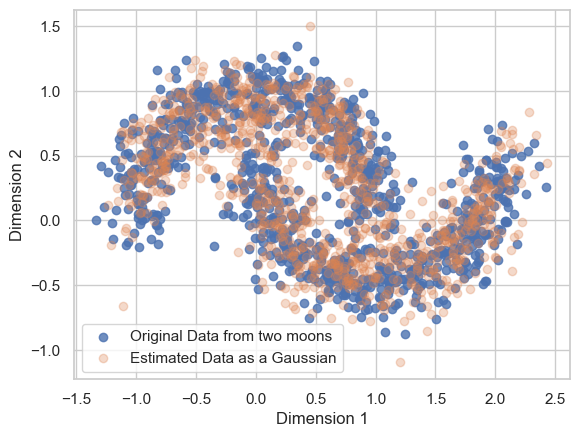

In [7]:
utils.plot_estimated_real_two_moons(X,estimated_data)

In [8]:
## MMD between real and estimated data
import torch
import matplotlib as plt

print(X.shape,estimated_data.shape)

result = utils.MMD(torch.tensor(X), torch.tensor(estimated_data), kernel="inverse_multi_quadratic")

print(f"MMD result of X and Y is {result.item()}")

(1000, 2) (1000, 2)
MMD result of X and Y is 0.00289299339056015


#### Influence of the number of components in the GMM

In [9]:
MMD_inverse_kernel = []
MMD_inverse_kernel_iterations = []

MAX_NO_COMPONENTs = 100
MAX_NO_ITERATIONS = 1000

for n_components in range(1,MAX_NO_COMPONENTs,3):
    estimated_data, _, _, _ = utils.train_GMM(X,n_components=n_components,max_iterations=100)
    result = utils.MMD(torch.tensor(X), torch.tensor(estimated_data), kernel="inverse_multi_quadratic")
    MMD_inverse_kernel += [(n_components,result.item())]


for max_iterations in range(50,MAX_NO_ITERATIONS,100):
    estimated_data, _, _, _ = utils.train_GMM(X,n_components=5,max_iterations=max_iterations)
    result = utils.MMD(torch.tensor(X), torch.tensor(estimated_data), kernel="inverse_multi_quadratic")
    MMD_inverse_kernel_iterations += [(max_iterations,result.item())]


 <div style="color: green; font-weight:
bold">A similar behaviour as the one provided in the solution. Increasing the number of components of the GMM minimizes the MMD at first, but then has little influence over it as the number of components increase.</div>

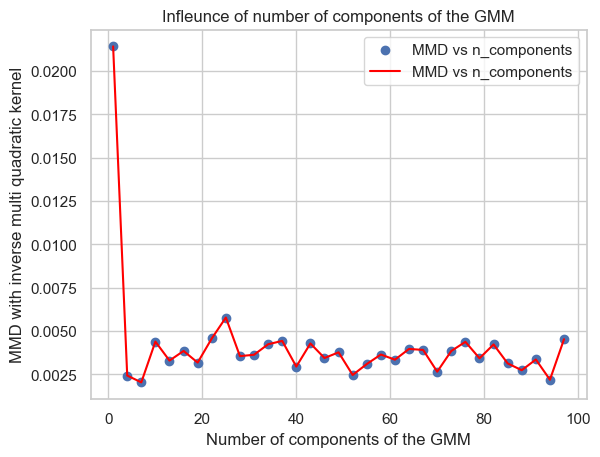

In [10]:
# Create a scatter plot
import matplotlib.pyplot as plt
plt.scatter([x[0] for x in MMD_inverse_kernel], [x[1] for x in MMD_inverse_kernel], label="MMD vs n_components")
plt.plot([x[0] for x in MMD_inverse_kernel], [x[1] for x in MMD_inverse_kernel], label="MMD vs n_components",color='red')

# Add labels and a legend
plt.xlabel("Number of components of the GMM")
plt.ylabel("MMD with inverse multi quadratic kernel")
plt.legend()

# Display the plot
plt.title('Infleunce of number of components of the GMM')
plt.show()

Conclusion: increasing the number of components brings an important improvement just when increasing from 1 to more components, as they offer more expressive power, after that there is no more improvement in reproducing the original data

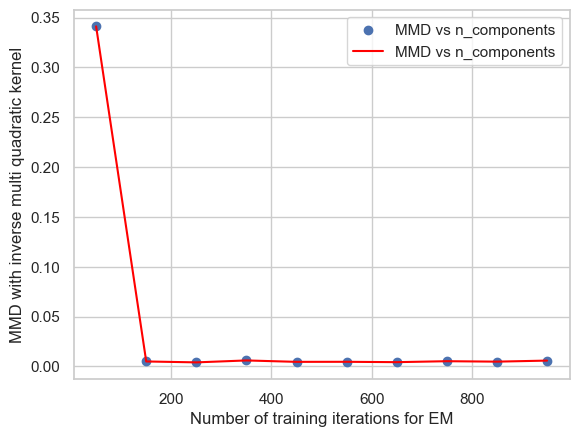

In [11]:
# Create a scatter plot
plt.scatter([x[0] for x in MMD_inverse_kernel_iterations], [x[1] for x in MMD_inverse_kernel_iterations], label="MMD vs n_components")
plt.plot([x[0] for x in MMD_inverse_kernel_iterations], [x[1] for x in MMD_inverse_kernel_iterations], label="MMD vs n_components",color='red')

# Add labels and a legend
plt.xlabel("Number of training iterations for EM")
plt.ylabel("MMD with inverse multi quadratic kernel")
plt.legend()

# Display the plot
plt.show()

Increasing the number of training iterations for the EM algorithm does not create a massive boost in performance after the first increase (100 to 200)